# Deep Neural Networks

## in PyTorch

In [1]:
import torch
import torch.nn as nn
from torch import sigmoid

In [2]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    def forward(self, x):
        x=sigmoid(self.linear1(x))       
        x=sigmoid(self.linear2(x))
        x=self.linear3(x)
        return x

## using nn.Sequential

In [3]:
input_dim = 2
hidden_dim1 = 6
hidden_dim2 = 4
output_dim = 3
model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim1),
    nn.Sigmoid(),
    nn.Linear(hidden_dim1, hidden_dim2),
    nn.Sigmoid(),    
    nn.Linear(hidden_dim2, output_dim)
)

## training

we create a validation and training dataset

In [4]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
train_dataset = dsets.MNIST(root='./data', train = True, download = True, transform=transforms.ToTensor())
validation_dataset = dsets.MNIST(root='./data', train = False, download = True, transform=transforms.ToTensor())

we create a validation and training loader

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=2000)

In [6]:
criterion = nn.CrossEntropyLoss()

we create the training function

In [7]:
from tqdm import tqdm
def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss': [],'validation_accuracy': []}  
    for epoch in tqdm(range(epochs)):
        for i, (x, y) in enumerate(train_loader): 
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
             #loss for every iteration
            useful_stuff['training_loss'].append(loss.data.item())
        correct = 0
        for x, y in validation_loader:
            #validation 
            z = model(x.view(-1, 28 * 28))
            _, label = torch.max(z, 1)
            correct += (label == y).sum().item()
        accuracy = 100 * (correct / len(validation_dataset))
        useful_stuff['validation_accuracy'].append(accuracy)
    return useful_stuff

We instantiate and Train the model

In [9]:
input_dim = 28 * 28
hidden_dim1 = 50
hidden_dim2 = 50
output_dim = 10

model = Net(input_dim, hidden_dim1, hidden_dim2, output_dim)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs=30)

100%|██████████| 30/30 [02:17<00:00,  4.58s/it]


Plot improper classified items

 # Deep Neural Networks : nn.ModuleList()

We create a list called layer,
the first element of the list is the feature size; in this case, two.
The second element of the list is the number of neurons in the first hidden layer;
in this case, three. The third element is the number of neurons in the second hidden layer, which is 4.
The fourth element is the number of classes in the output layer, which is three in this case. 

In [10]:
import torch
import torch.nn as nn
from torch import sigmoid

In [11]:
class Net(nn.Module):
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

In [13]:
Layers = [2, 3, 4, 3]
model = Net(Layers)

 [jdc](https://alexhagen.github.io/jdc/) : Jupyter magic that allows defining classes over multiple jupyter notebook cells.

In [15]:
import jdc


In [16]:
%%add_to Net

def forward(self, x):
    L = len(self.hidden)
    for (l, linear_transform) in zip(range(L), self.hidden):
        if (l < L-1):
            x = torch.relu(linear_transform(x))
        else:
            x = linear_transform(x)
    return x

# Dropout

## using nn.Module

In [17]:
class Net(nn.Module):
    def __init__(self, in_size, n_hidden, out_size, p=0):
        super(Net, self).__init__()
        self.drop = nn.Dropout(p=p)
        self.linear1 = nn.Linear(in_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, out_size)
    def forward(self, x):
        x=torch.relu(self.linear1(x))       
        x=self.drop(x)
        x=torch.relu(self.linear2(x))
        x=self.drop(x)
        x=self.linear3(x)
        return x

## using nn.Sequential

In [30]:
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(10, 12),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(12, 1),
)

## training

In [31]:
from torch.utils.data import Dataset, DataLoader 
import numpy as np
# Create data class for creating dataset object

class Data(Dataset):
    
    # Constructor
    def __init__(self, N_SAMPLES=1000, noise_std=0.15, train=True):
        a = np.matrix([-1, 1, 2, 1, 1, -3, 1]).T
        self.x = np.matrix(np.random.rand(N_SAMPLES, 2))
        self.f = np.array(a[0] + (self.x) * a[1:3] + np.multiply(self.x[:, 0], self.x[:, 1]) * a[4] + np.multiply(self.x, self.x) * a[5:7]).flatten()
        self.a = a
       
        self.y = np.zeros(N_SAMPLES)
        self.y[self.f > 0] = 1
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)
        self.x = self.x + noise_std * torch.randn(self.x.size())
        self.f = torch.from_numpy(self.f)
        self.a = a
        if train == True:
            torch.manual_seed(1)
            self.x = self.x + noise_std * torch.randn(self.x.size())
            torch.manual_seed(0)
        
    # Getter        
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot(self):
        X = data_set.x.numpy()
        y = data_set.y.numpy()
        h = .02
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max() 
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = data_set.multi_dim_poly(np.c_[xx.ravel(), yy.ravel()]).flatten()
        f = np.zeros(Z.shape)
        f[Z > 0] = 1
        f = f.reshape(xx.shape)
        
        plt.title('True decision boundary  and sample points with noise ')
        plt.plot(self.x[self.y == 0, 0].numpy(), self.x[self.y == 0,1].numpy(), 'bo', label='y=0') 
        plt.plot(self.x[self.y == 1, 0].numpy(), self.x[self.y == 1,1].numpy(), 'ro', label='y=1')
        plt.contour(xx, yy, f,cmap=plt.cm.Paired)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.legend()
    
    # Make a multidimension ploynomial function
    def multi_dim_poly(self, x):
        x = np.matrix(x)
        out = np.array(self.a[0] + (x) * self.a[1:3] + np.multiply(x[:, 0], x[:, 1]) * self.a[4] + np.multiply(x, x) * self.a[5:7])
        out = np.array(out)
        return out

In [33]:
model_drop = Net(2, 300, 2, p=0.5)


**train method** tells the model we are in the training phase which will implement the dropout method, later we use the dot eval method to tell the model it is in the evaluation phase
and that will turn off the dropout method

In [34]:
model_drop.train()
optimizer = torch.optim.Adam(model_drop.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()
data_set = Data()
validation_set = Data(train=False)



In [35]:
# Initialize the LOSS dictionary to store the loss

LOSS = {}
LOSS['training data dropout'] = []
LOSS['validation data dropout'] = []

In [38]:
# Train the model
from tqdm import tqdm

epochs = 500

def train_model(epochs):
    
    for epoch in tqdm(range(epochs)):
        #all the samples are used for training 
        yhat_drop = model_drop(data_set.x)
        loss_drop = criterion(yhat_drop, data_set.y)

        #store the loss for both the training and validation data for both models 
        LOSS['training data dropout'].append(loss_drop.item())
        model_drop.eval()
        LOSS['validation data dropout'].append(criterion(model_drop(validation_set.x), validation_set.y).item())
        model_drop.train()

        optimizer.zero_grad()
        loss_drop.backward()
        optimizer.step()
        
train_model(epochs)

100%|██████████| 500/500 [00:02<00:00, 212.71it/s]


In [40]:
# The function for calculating accuracy

def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()

In [41]:
# Print out the accuracy of the model with dropout

print("The accuracy of the model with dropout: ", accuracy(model_drop, validation_set))

The accuracy of the model with dropout:  0.866


# Neural Network initialization weights

# Gradient descent with Momentum

In [42]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum = 0.4)

# Batch Normalization

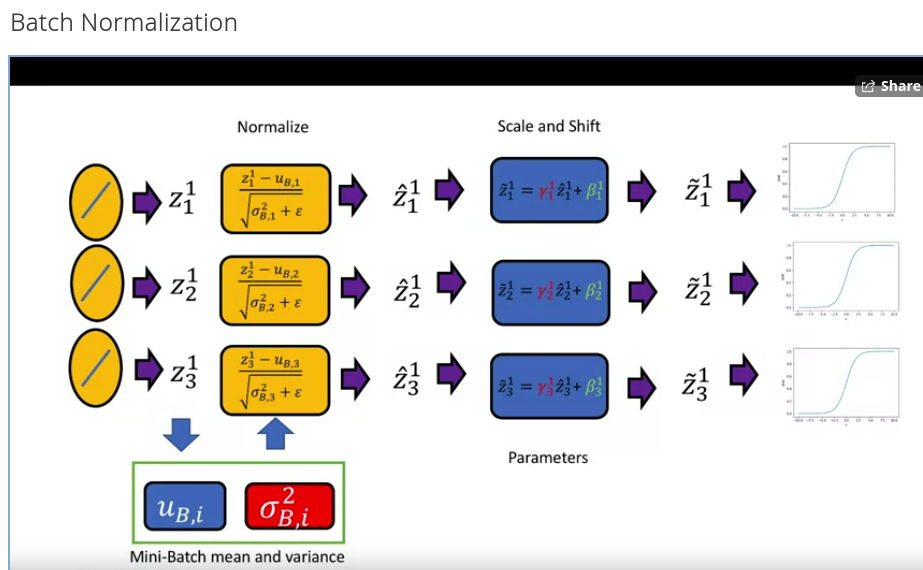

$\gamma$, $\beta$ parameters are are actually scale and shift parameters, which we're going to learn via training. 

## using nn.Module

In [2]:
class Net_BatchNorm(nn.Module):
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):
        super(Net_BatchNorm, self).__init__()

        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
        
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)
        
    def forward(self, x):
        x=torch.sigmoid(self.bn1(self.linear1(x)))
        x=torch.sigmoid(self.bn2(self.linear2(x)))
        x=self.linear3(x)
        return x